In [7]:
from torchsummary                 import summary
from tqdm                         import tqdm
from src.data.to_tensor           import ToTensor
from src.data.mrw_dataset         import MRWDataset
from src.data.create_data_loaders import create_data_loaders
from src.nn.archs                 import CNN_ALL, CNN_ALL_VDCNNFRW_M18
from src.nn.results.utils         import (get_all_predictions, analyse_predictions, 
                                            plot_distributions, plot_losses, get_MSEs)

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.num_ctes  as nctes
import src.ctes.str_ctes  as sctes
import src.ctes.path_ctes as pctes

In [8]:
builder = CNN_ALL_VDCNNFRW_M18

In [9]:
data_path = pctes.DATAPATH
timestamp = "2024_02_07__18_38_23"
arch_name = builder.__name__
hyperparams_path = f"../../../data/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../../data/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../../data/losses_{arch_name}_{timestamp}.png"

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [11]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../../data/hyperparams_CNN_ALL_VDCNNFRW_M18_2024_02_07__18_38_23.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [12]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [13]:
sample_size = nctes.LEN_SAMPLE
model = builder(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Sequential: 2-1                   [-1, 64, 8173]            --
|    |    └─Conv1d: 3-1                  [-1, 64, 8173]            5,120
|    |    └─BatchNorm1d: 3-2             [-1, 64, 8173]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8173]            --
|    └─MaxPool1d: 2-2                    [-1, 64, 2043]            --
|    └─Sequential: 2-3                   [-1, 64, 2041]            --
|    |    └─Conv1d: 3-4                  [-1, 64, 2041]            12,288
|    |    └─BatchNorm1d: 3-5             [-1, 64, 2041]            128
|    |    └─ReLU: 3-6                    [-1, 64, 2041]            --
|    └─Sequential: 2-4                   [-1, 64, 2039]            --
|    |    └─Conv1d: 3-7                  [-1, 64, 2039]            12,288
|    |    └─BatchNorm1d: 3-8             [-1, 64, 2039]            128
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─Sequential: 2-1                   [-1, 64, 8173]            --
|    |    └─Conv1d: 3-1                  [-1, 64, 8173]            5,120
|    |    └─BatchNorm1d: 3-2             [-1, 64, 8173]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8173]            --
|    └─MaxPool1d: 2-2                    [-1, 64, 2043]            --
|    └─Sequential: 2-3                   [-1, 64, 2041]            --
|    |    └─Conv1d: 3-4                  [-1, 64, 2041]            12,288
|    |    └─BatchNorm1d: 3-5             [-1, 64, 2041]            128
|    |    └─ReLU: 3-6                    [-1, 64, 2041]            --
|    └─Sequential: 2-4                   [-1, 64, 2039]            --
|    |    └─Conv1d: 3-7                  [-1, 64, 2039]            12,288
|    |    └─BatchNorm1d: 3-8             [-1, 64, 2039]            128
|

In [14]:
transform = ToTensor()

data      = MRWDataset(data_path, transform, sample_size, builder.LABELS)

In [15]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [16]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [17]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [18]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
# print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {hyperparams[sctes.DROPOUT_PROBS].tolist()}")
print(f"Labels           = {builder.LABELS}")

Model name       = Top-Down v2
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 2
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)
Seed             = 42.0
Dropout probas    = []
Labels           = ['c1', 'c2', 'L', 'EPSILON']


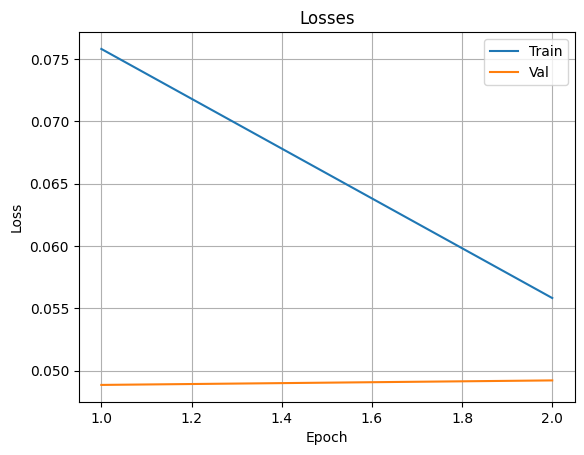

In [19]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [20]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, builder.LABELS)

100%|██████████| 427/427 [00:01<00:00, 239.55it/s]


In [21]:
analyse_predictions(targets, preds)

True values of c1 and their count : 
0.0: 665 occurrences
0.3333333432674408: 625 occurrences
0.6666666865348816: 635 occurrences
1.0: 635 occurrences

Predicted values of c1 and their count: 
7.339717171817028e-07: 1 occurrences
1.1710000080711325e-06: 1 occurrences
3.762474761970225e-06: 1 occurrences
4.330018782638945e-06: 1 occurrences
4.731293302029371e-06: 1 occurrences
4.9185132411366794e-06: 1 occurrences
5.010550012229942e-06: 1 occurrences
5.6613071137689985e-06: 1 occurrences
5.910172149015125e-06: 1 occurrences
7.003822247497737e-06: 1 occurrences
9.856634278548881e-06: 1 occurrences
1.0009408470068593e-05: 1 occurrences
1.0101776751980651e-05: 1 occurrences
1.1209154763491824e-05: 1 occurrences
1.1480520697659813e-05: 1 occurrences
1.1737571185221896e-05: 1 occurrences
1.2046518349961843e-05: 1 occurrences
1.2926376257382799e-05: 1 occurrences
1.2959431842318736e-05: 1 occurrences
1.3701570424018428e-05: 1 occurrences
1.4270858628151473e-05: 1 occurrences
1.611347397556528

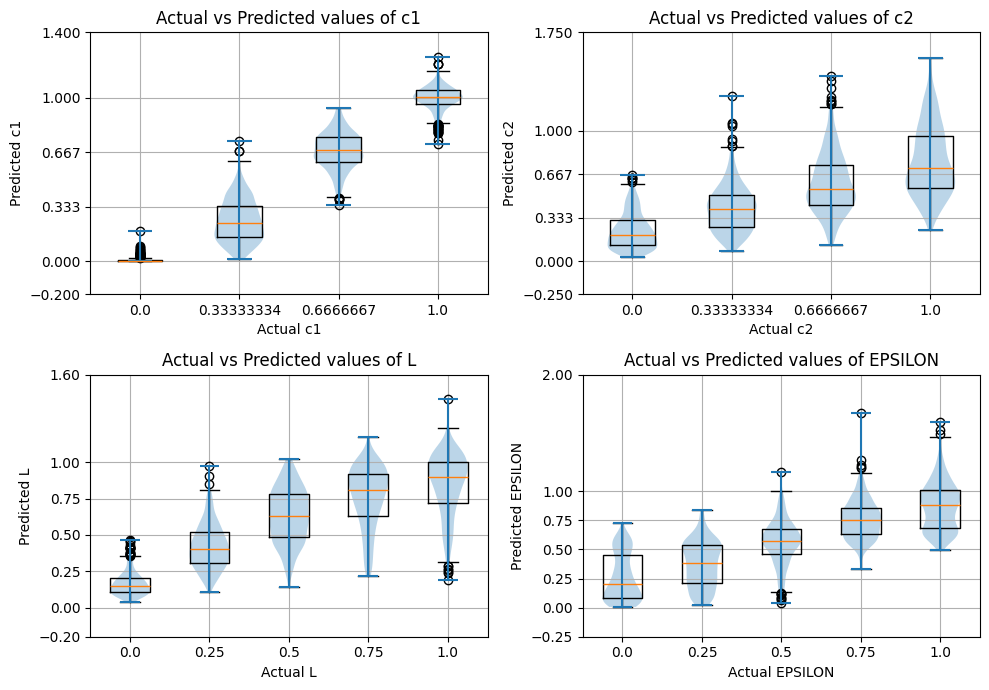

In [22]:
plot_distributions(targets, preds, builder.LABELS)

In [23]:
total_test_loss, mean_output_losses = get_MSEs(targets, preds, output_losses, builder.LABELS, device, criterion)
print("Total Test MSE = {:0.4f}".format(total_test_loss))
print("")
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

Total Test MSE = 0.0476

Test MSE for each output:
c1: 0.0102
c2: 0.0735
L: 0.0501
EPSILON: 0.0567


In [24]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"              c1         c2         L         epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {['{:0.4f}'.format(output_losses[p][i]) for p in range(len(builder.LABELS))]}")
    print()

10 Worst Results ==>
              c1         c2         L         epsilon
Target      = ['1.0000', '1.0000', '0.5000', '1.0000']
Prediction  = ['1.0296', '0.6747', '0.6456', '0.6816']
MSE         = ['0.0060', '0.1951', '0.0335', '0.0400']

              c1         c2         L         epsilon
Target      = ['0.3333', '0.6667', '0.5000', '0.7500']
Prediction  = ['0.3239', '1.0180', '0.6930', '0.7643']
MSE         = ['0.0072', '0.0617', '0.0218', '0.1026']

              c1         c2         L         epsilon
Target      = ['1.0000', '0.0000', '1.0000', '0.5000']
Prediction  = ['1.0290', '0.3984', '0.9672', '0.5973']
MSE         = ['0.0231', '0.0153', '0.0227', '0.0616']

              c1         c2         L         epsilon
Target      = ['0.6667', '0.3333', '0.2500', '0.0000']
Prediction  = ['0.4957', '0.3144', '0.4693', '0.1266']
MSE         = ['0.0175', '0.1359', '0.0335', '0.0380']

              c1         c2         L         epsilon
Target      = ['0.3333', '0.0000', '0.2500', 

In [25]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"              {[label + '    ' for label in builder.LABELS]}")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"MSE         = {['{:0.4f}'.format(output_losses[p][-i]) for p in range(len(builder.LABELS))]}")
    print()

10 Best Results ==>
              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.6667', '0.0000', '0.7500']
Prediction  = ['0.2000', '0.6924', '0.0931', '0.8836']
MSE         = ['0.0175', '0.0649', '0.0043', '0.0324']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['1.0000', '0.6667', '0.2500', '0.5000']
Prediction  = ['1.0135', '0.5321', '0.3493', '0.5704']
MSE         = ['0.0058', '0.0731', '0.0439', '0.0369']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.0000', '1.0000', '0.2500']
Prediction  = ['0.4891', '0.1852', '1.0449', '0.5125']
MSE         = ['0.0020', '0.0789', '0.0626', '0.0609']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.3333', '0.5000', '0.7500']
Prediction  = ['0.2589', '0.4819', '0.4225', '0.3357']
MSE         = ['0.0170', '0.0824', '0.0463', '0.0490']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.333